# Titel
## Mauro Schegg
## 3.3.2025

## Einleitung:

## Zielsetzung und Vorgehensweise:
Es soll ein Modell erstellt werden welches Zeitreihenprognosen erstellt. Es soll ein RNN mit LSTM angewendet werden um diese Prognosen zu erstellen. 

## EDA:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Einlesen der Daten
dfp = pd.read_csv('Daten/train.csv')
dfwf1 = pd.read_csv('Daten/windforecasts_wf1.csv')
dfwf2 = pd.read_csv('Daten/windforecasts_wf2.csv')
dfwf3 = pd.read_csv('Daten/windforecasts_wf3.csv')
dfwf4 = pd.read_csv('Daten/windforecasts_wf4.csv')
dfwf5 = pd.read_csv('Daten/windforecasts_wf5.csv')
dfwf6 = pd.read_csv('Daten/windforecasts_wf6.csv')
dfwf7 = pd.read_csv('Daten/windforecasts_wf7.csv')

In [3]:
# Methode zur Umwandlung in datetime für alle DataFrames
def convert_to_datetime(dfs):
	for df in dfs:
		df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
	return dfs

# Liste der DataFrames
dfs = [dfp,dfwf1, dfwf2, dfwf3, dfwf4, dfwf5, dfwf6, dfwf7]

# Aufruf der Funktion
dfs = convert_to_datetime(dfs)

In [4]:
# Die ersten 5 Zeilen der Leistung der Windparks
dfp.head()

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2,2009-07-01 02:00:00,0.020,0.175,0.178,0.033,0.015,0.026,0.000
3,2009-07-01 03:00:00,0.060,0.085,0.109,0.022,0.010,0.013,0.000
4,2009-07-01 04:00:00,0.045,0.032,0.079,0.039,0.010,0.000,0.000


In [5]:
# Die ersten 5 Zeilen der Windvorhersagen für Windpark 1
dfwf1.head()

,date,hors,u,v,ws,wd
0,2009-07-01,1,2.34,-0.79,2.47,108.68
1,2009-07-01,2,2.18,-0.99,2.40,114.31
2,2009-07-01,3,2.20,-1.21,2.51,118.71
3,2009-07-01,4,2.35,-1.40,2.73,120.86
4,2009-07-01,5,2.53,-1.47,2.93,120.13


**Erkenntnisse:**
- Es werden alle 12h die Winddaten für 48h vorraus gesagt, dies bedeutet, dass es 4 Vorhersagen für die meisten Zeitpunkte gibt.

In [6]:
# Dimensionen des Datensatzes
print(dfp.shape)
print(dfwf1.shape)

(18757, 8)
(104832, 6)


- Das DataFrame für die Leistungen der Windpark hat 8 Spalten eine davon ist die Zeit, das heisst es hat 7 Windparks.

In [7]:
# Analyse der Datentypen
dfp.dtypes

date    datetime64[ns]
wp1            float64
wp2            float64
wp3            float64
wp4            float64
wp5            float64
wp6            float64
wp7            float64
dtype: object

In [8]:
# Überprüfen des leistungs DataFrames auf fehlende Werte
print(dfp.isna().sum())

date    0
wp1     0
wp2     0
wp3     0
wp4     0
wp5     0
wp6     0
wp7     0
dtype: int64


In [9]:
# Überprüfen des leistungs DataFrames auf fehlende Werte
print(dfwf1.isna().sum())

date        0
hors        0
u       11160
v       11160
ws      11160
wd      11160
dtype: int64


In [10]:
# Fehlende Werte durch Mittelwert ersetzen.
# dfs = [dfwf1, dfwf2, dfwf3, dfwf4, dfwf5, dfwf6, dfwf7]
# for i in range(len(dfs)):
    # dfs[i].fillna(dfs[i].mean(), inplace=True)

In [11]:
dfwf1.isna().sum()

date        0
hors        0
u       11160
v       11160
ws      11160
wd      11160
dtype: int64

- Es hat keine fehlenden Daten im leistungs Datensatz.
- Es hat $11160$ fehlende Daten bei jeder der Spalten $u,v,w_s,w_d$. Dies sind etwa $11\%$ der gesamten Daten.

### Deskriptive Statistik:

<Axes: >

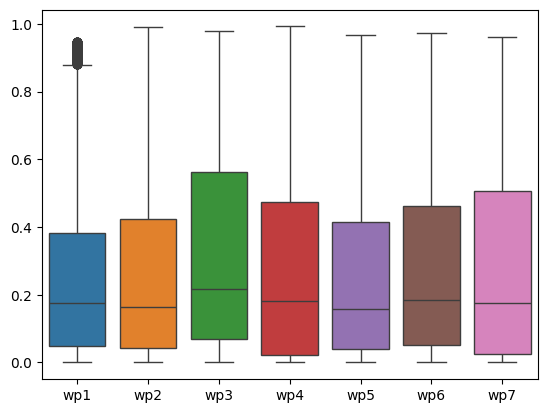

In [12]:
dfp.describe()
sns.boxplot(dfp)

- Jedes dieser Boxplots beschreibt die normalisierten Daten für die Leistung eines Windparks.
- Windpark 1 scheint Aussreisser zu haben welche betrachtet werden müssen.

### Umwandlung des leistungs Datensatzes:

In [13]:
# Umwandlung dfp
dfp = dfp.rename(columns={"wp1":"wf1","wp2":"wf2","wp3":"wf3","wp4":"wf4","wp5":"wf5","wp6":"wf6","wp7":"wf7"})
# Zusammenführen der Leistungen in eine Spalte
dfp = dfp.melt(id_vars=["date"], value_name="wpower",var_name="wfarm",ignore_index=True)
dfp["wfarm"] = dfp["wfarm"].astype("string")
dfp.dtypes

date      datetime64[ns]
wfarm     string[python]
wpower           float64
dtype: object

In [14]:
dfp.head()

,date,wfarm,wpower
0,2009-07-01 00:00:00,wf1,0.045
1,2009-07-01 01:00:00,wf1,0.085
2,2009-07-01 02:00:00,wf1,0.020
3,2009-07-01 03:00:00,wf1,0.060
4,2009-07-01 04:00:00,wf1,0.045


### Prognosen:

<Axes: >

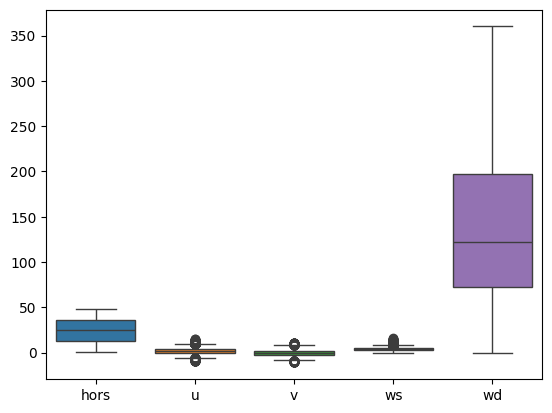

In [15]:
sns.boxplot(dfwf1)

**Zeitabschnitte**
- hors beschreibt die wie vielte Stunde der Vorhersage das es ist. Dies sind Werte von 1-48.

**Kartesische Koordinaten:**
- u beschreibt die Windgeschwindigkeit in Ost-West-Richtung
- v beschreibt die Windgeschwindigkeit in Nord-Süd-Richtung

**Polar Koordinaten:***
- ws = $\sqrt{u^2+v^2}$ Betrag des Geschwindigkeitsvektors
- wf beschreibt die Richtung des Windes in Grad

In [16]:
# Liste der DataFrames und zugehörige Keys
dfs = [dfwf1, dfwf2, dfwf3, dfwf4, dfwf5, dfwf6, dfwf7]
keys = ["wf1", "wf2", "wf3", "wf4", "wf5", "wf6", "wf7"]

# Neue DataFrames mit 'wfarm'-Spalte erstellen
dfs = [df.assign(wfarm=key) for df, key in zip(dfs, keys)]

# DataFrames zusammenfügen
dfw = pd.concat(dfs, ignore_index=True)

# Spalten umsortieren, damit 'wfarm' ganz links steht
cols = ["wfarm"] + [col for col in dfw.columns if col != "wfarm"]
dfw = dfw[cols]

# Ergebnis anzeigen
dfw.head()

,wfarm,date,hors,u,v,ws,wd
0,wf1,2009-07-01,1,2.34,-0.79,2.47,108.68
1,wf1,2009-07-01,2,2.18,-0.99,2.40,114.31
2,wf1,2009-07-01,3,2.20,-1.21,2.51,118.71
3,wf1,2009-07-01,4,2.35,-1.40,2.73,120.86
4,wf1,2009-07-01,5,2.53,-1.47,2.93,120.13


In [17]:
dfw["forecast"] = pd.to_datetime(dfw["date"],format="%Y%m%d%H")
dfw["delta_hours"] = pd.to_timedelta(dfw["hors"],unit="hours")
dfw["forecast_date"] = dfw["forecast"]+dfw["delta_hours"]

In [18]:
# Encoding periodischer Merkmale
# Richtung
dfw["wd_sin"] = np.sin(2*np.pi*dfw["wd"]/360)
dfw["wd_cos"] = np.cos(2**np.pi*dfw["wd"]/360)
# Monat
dfw["month"] = dfw.forecast_date.dt.month
dfw["month_sin"] = np.sin(2**np.pi*dfw["month"]/12)
dfw["month_cos"] = np.cos(2**np.pi*dfw["month"]/12)
# Tag
dfw["day"] = dfw.forecast_date.dt.day
dfw["day_sin"] = np.sin(2**np.pi*dfw["day"]/31)
dfw["day_cos"] = np.cos(2**np.pi*dfw["day"]/31)
# Stunde
dfw["hour"] = dfw.forecast_date.dt.hour
dfw["hour_sin"] = np.sin(2**np.pi*dfw["hour"]/24)
dfw["hour_cos"] = np.cos(2**np.pi*dfw["hour"]/24)


In [19]:
# Gleitender Mittelwert
hgm = 6 
dfw["u_gm"] = dfw.u.rolling(hgm).mean()
dfw["v_gm"] = dfw.v.rolling(hgm).mean()
dfw["ws_gm"] = dfw.ws.rolling(hgm).mean()

In [20]:
del dfw["forecast"]

### Merge:

In [21]:
# Verbindung der beiden Dataframes
df = dfp.merge(dfw,how="outer",left_on=["date","wfarm"],right_on=["forecast_date","wfarm"])  

In [22]:
del df["date_x"]
del df["date_y"]
del df["hors"]

In [23]:
df.head(100)

,wfarm,wpower,u,v,ws,wd,delta_hours,forecast_date,wd_sin,wd_cos,...,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos,u_gm,v_gm,ws_gm
0,wf1,0.045,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wf2,0.233,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,wf3,0.494,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,wf4,0.105,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,wf5,0.056,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,wf3,0.000,1.51,-1.99,2.49,142.77,0 days 13:00:00,2009-07-01 13:00:00,0.605016,-0.936513,...,0.421877,1.0,0.280847,0.959752,13.0,-0.997702,0.067755,1.591667,-1.880000,2.468333
96,wf3,0.000,1.88,-1.75,2.57,133.00,0 days 01:00:00,2009-07-01 13:00:00,0.731354,-0.992958,...,0.421877,1.0,0.280847,0.959752,13.0,-0.997702,0.067755,2.621667,-1.525000,3.051667
97,wf4,0.000,3.34,-0.65,3.40,101.04,0 days 13:00:00,2009-07-01 13:00:00,0.981494,-0.787092,...,0.421877,1.0,0.280847,0.959752,13.0,-0.997702,0.067755,3.133333,-1.006667,3.315000
98,wf4,0.000,3.36,-0.90,3.48,105.02,0 days 01:00:00,2009-07-01 13:00:00,0.965835,-0.843435,...,0.421877,1.0,0.280847,0.959752,13.0,-0.997702,0.067755,3.228333,-1.678333,3.701667


In [24]:
df.isna().sum()

wfarm                 0
wpower           209160
u                 78127
v                 78127
ws                78127
wd                78127
delta_hours           7
forecast_date         7
wd_sin            78127
wd_cos            78127
month                 7
month_sin             7
month_cos             7
day                   7
day_sin               7
day_cos               7
hour                  7
hour_sin              7
hour_cos              7
u_gm              94407
v_gm              94407
ws_gm             94407
dtype: int64

### Heatmap:

In [25]:
df.columns

Index(['wfarm', 'wpower', 'u', 'v', 'ws', 'wd', 'delta_hours', 'forecast_date',
       'wd_sin', 'wd_cos', 'month', 'month_sin', 'month_cos', 'day', 'day_sin',
       'day_cos', 'hour', 'hour_sin', 'hour_cos', 'u_gm', 'v_gm', 'ws_gm'],
      dtype='object')

<Axes: >

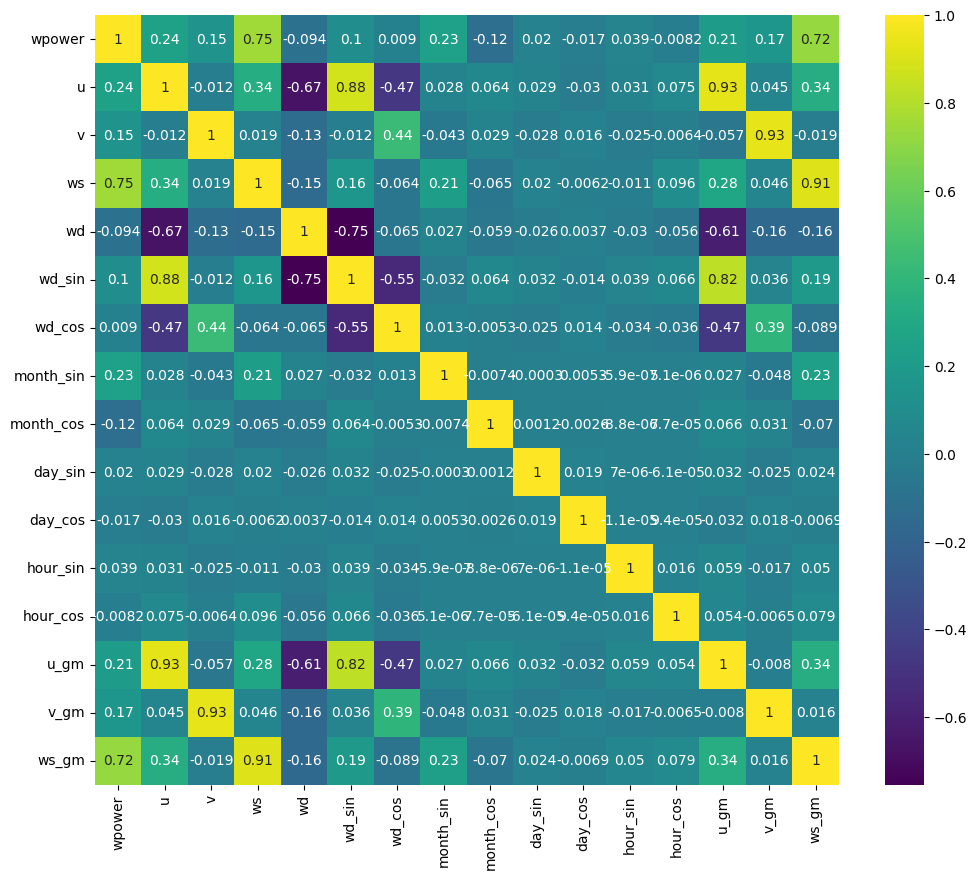

In [26]:
corr = df[['wpower', 'u', 'v', 'ws', 'wd','wd_sin', 'wd_cos','month_sin', 'month_cos','day_sin',
       'day_cos','hour_sin', 'hour_cos', 'u_gm', 'v_gm', 'ws_gm']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr,annot=True,cmap="viridis")

In [27]:
# sns.pairplot(df.sample(n=250))

## Random Tree um die wichtigsten Features zu finden:

In [28]:
dfTest = df.sample(2000)
dfTest.dropna(axis=0,inplace=True)
dfTest.isna().sum()

wfarm            0
wpower           0
u                0
v                0
ws               0
wd               0
delta_hours      0
forecast_date    0
wd_sin           0
wd_cos           0
month            0
month_sin        0
month_cos        0
day              0
day_sin          0
day_cos          0
hour             0
hour_sin         0
hour_cos         0
u_gm             0
v_gm             0
ws_gm            0
dtype: int64

In [29]:
dfTest.head()

,wfarm,wpower,u,v,ws,wd,delta_hours,forecast_date,wd_sin,wd_cos,...,month_cos,day,day_sin,day_cos,hour,hour_sin,hour_cos,u_gm,v_gm,ws_gm
341180,wf6,0.289,-3.84,1.88,4.27,296.17,1 days 11:00:00,2010-11-21 11:00:00,-0.897489,0.559449,...,-0.233408,21.0,-0.300269,0.953855,11.0,-0.785305,-0.619109,-3.351667,0.910000,3.503333
1149,wf6,0.158,4.62,-3.60,5.86,127.96,0 days 23:00:00,2009-07-03 11:00:00,0.788440,-0.999988,...,0.421877,3.0,0.753934,0.656950,11.0,-0.785305,-0.619109,4.568333,-2.855000,5.396667
278848,wf5,0.066,0.79,0.59,0.99,53.21,1 days 05:00:00,2010-08-20 17:00:00,0.800836,0.263275,...,0.921113,20.0,-0.556071,0.831135,17.0,-0.032154,0.999483,-0.991667,-0.748333,1.588333
207674,wf5,0.920,9.73,-0.31,9.73,91.81,0 days 07:00:00,2010-05-06 19:00:00,0.999501,-0.628652,...,-0.860023,6.0,0.990594,-0.136833,19.0,0.646704,0.762741,8.688333,0.518333,8.716667
676517,wf1,0.005,-0.33,0.57,0.66,329.48,1 days 00:00:00,2012-04-03 12:00:00,-0.507839,-0.220995,...,-0.980080,3.0,0.753934,0.656950,12.0,-0.955366,-0.295425,0.005000,-1.656667,1.905000


In [30]:
X = dfTest[['u', 'v', 'ws', 'wd','wd_sin', 'wd_cos','month_sin', 'month_cos',
       'day_cos','hour_sin', 'hour_cos', 'u_gm']]
y = dfTest["wpower"]

# Entscheidungsbaum-Regression mit max_depth
forest = RandomForestRegressor(n_estimators=1000,max_depth=250,random_state=None)
forest.fit(X, y)

RandomForestRegressor(max_depth=250, n_estimators=1000)

In [31]:
feature_importance = forest.feature_importances_
importance_df = pd.DataFrame({"Features":X.columns,"Importance":feature_importance})
importance_df.sort_values(by="Importance",ascending=False)

,Features,Importance
2,ws,0.644096
1,v,0.053387
11,u_gm,0.045319
10,hour_cos,0.034981
9,hour_sin,0.032881
3,wd,0.032866
8,day_cos,0.032228
0,u,0.028003
7,month_cos,0.025341
4,wd_sin,0.024349


In [32]:
top_features = importance_df.sort_values(by="Importance",ascending=False).head(6)
top_features

,Features,Importance
2,ws,0.644096
1,v,0.053387
11,u_gm,0.045319
10,hour_cos,0.034981
9,hour_sin,0.032881
3,wd,0.032866


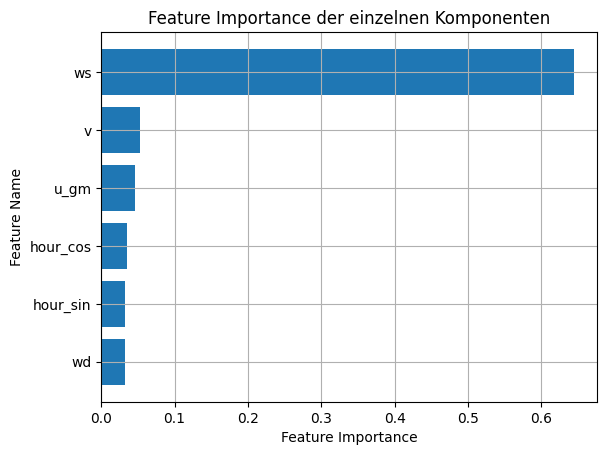

In [33]:
plt.barh(top_features["Features"],top_features["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance der einzelnen Komponenten")
plt.gca().invert_yaxis()
plt.grid()

- Wie zu erwarten ist die Windgeschwindigkeit einer der wichtigsten Faktoren für die Leistung eines Windkraftwerks.
- $ws_{gm}$, $v_{gm}$, $day_{sin}$ wurden entfernt das sie sonst doppelt representiert sind.

## Bewertungskriterium:
- Es wird danach bewertet wie gut das Modell die Leistung vorraus sagt.
- Dazu wird die **Root Mean Squared Error (RMSE)** Loss Funktion verwendet, da sie grosse Fehler bestraft und das Ergebnis in der Einheit der Leistung interpretiert werden kann.

## Bewertungsmethode
- Holdout-Methode kann verwendet werden, da der Datensatz sehr gross ist.

## Baseline-Modell:
- Für das Baseline-Modell wird ein LTSM verwendet welches speziell für Zeitabhängige Daten entwickelt wurde. RNN haben das *Vanishing Gradient* Problem, dies hat LTSM nicht. 
- Das *Vanishing Gradient* Problem ist wenn die Gradienten während des Backpropagation-Trainings immer kleiner werden.

In [34]:

# Parameter für die LSTM-Eingabe
TIME_STEPS = 48  # Anzahl vergangener Stunden für die Vorhersage der nächsten Stunde

# Modell-Parameter
input_size = 6  # Anzahl der Features
output_size = 1
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
hidden_sizes = [50, 100, 150]
num_layers_list = [2, 3, 4]  # Verschiedene Anzahl der LSTM-Schichten

# LSTM Modell definieren
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Nur letztes Zeitfenster nutzen

# Modell, Verlustfunktion und RMSE-Definition
criterion = nn.MSELoss()

def compute_rmse(y_pred, y_true):
    mse = criterion(y_pred, y_true)
    rmse = torch.sqrt(mse)  # RMSE Loss Funktion
    return rmse

# Liste der Resultate 
results = []

# Iteration über alle Windparks und Kombinationen der Hyperparameter
for wf_id in dfTest["wfarm"].unique():
    print(f"Training für Windpark {wf_id}...")

    # Filtern der Daten für den Windpark
    df_wf = dfTest[dfTest["wfarm"] == "wf1"]

    # Features und Zielvariable
    X = torch.tensor(df_wf[["ws", "u_gm", "v", "day_cos", "hour_cos", "month_sin"]].values, dtype=torch.float32)
    y = torch.tensor(df_wf["wpower"].values, dtype=torch.float32).view(-1, 1)  # 2D-Shape für LSTM

    # Min-Max-Normalisierung mit PyTorch (statt Sklearn)
    y_min, y_max = y.min(), y.max()
    y_scaled = (y - y_min) / (y_max - y_min)

    # Funktion zur Erstellung von Sequenzen für das LSTM
    def create_sequences(X, y, time_steps):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:i + time_steps])  # 48 Werte als Eingabe
            ys.append(y[i + time_steps])    # Der nächste Wert als Ziel
        return torch.stack(Xs), torch.stack(ys)

    # Erstelle die Sequenzen
    X_seq, y_seq = create_sequences(X, y_scaled, TIME_STEPS)

    # Holdout-Methode: Train (70%), Validation (10%), Test (20%) Split
    train_split = int(0.7 * len(X_seq))
    val_split = int(0.8 * len(X_seq))  # 70% + 10% = 80%

    X_train, X_val, X_test = X_seq[:train_split], X_seq[train_split:val_split], X_seq[val_split:]
    y_train, y_val, y_test = y_seq[:train_split], y_seq[train_split:val_split], y_seq[val_split:]

    # Prüfe die Shapes
    print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
    print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
    print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

    # Testen der verschiedenen Lernraten, versteckten Schichtgrößen und LSTM-Schichten
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for num_layers in num_layers_list:
                print(f"Training mit Lernrate: {lr}, Hidden Size: {hidden_size}, num_layers: {num_layers}...")

                # Modell neu erstellen mit den aktuellen Hyperparametern
                model = LSTMModel(input_size, hidden_size, num_layers, output_size)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Training
                EPOCHS = 50
                for epoch in range(EPOCHS):
                    model.train()
                    optimizer.zero_grad()
                    y_pred = model(X_train)
                    loss = compute_rmse(y_pred, y_train)
                    loss.backward()
                    optimizer.step()

                    # Validierung
                    model.eval()
                    with torch.no_grad():
                        val_pred = model(X_val)
                        val_loss = compute_rmse(val_pred, y_val)

                    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

                # Modell testen
                model.eval()
                with torch.no_grad():
                    y_test_pred = model(X_test)

                # Test-Fehler berechnen
                test_loss = compute_rmse(y_test_pred, y_test)
                print(f"Test Loss für Windpark {wf_id} mit Lernrate {lr}, Hidden Size {hidden_size}, und num_layers {num_layers}: {test_loss.item():.4f}")

                # Ergebnisse speichern
                results.append({
                    "wf_id": wf_id,
                    "learning_rate": lr,
                    "hidden_size": hidden_size,
                    "num_layers": num_layers,
                    "test_loss": test_loss.item()
                })

# Speichern der Ergebnisse in einem DataFrame
results_df = pd.DataFrame(results)

# Ausgabe der Resultate
print(results_df)


Training für Windpark wf6...
X_train Shape: torch.Size([112, 48, 6]), y_train Shape: torch.Size([112, 1])
X_val Shape: torch.Size([16, 48, 6]), y_val Shape: torch.Size([16, 1])
X_test Shape: torch.Size([32, 48, 6]), y_test Shape: torch.Size([32, 1])
Training mit Lernrate: 0.1, Hidden Size: 50, num_layers: 2...
Epoch 1/50, Loss: 0.4261, Val Loss: 3.6507
Epoch 2/50, Loss: 3.5950, Val Loss: 0.8037
Epoch 3/50, Loss: 0.7705, Val Loss: 1.9882
Epoch 4/50, Loss: 2.0221, Val Loss: 1.2917
Epoch 5/50, Loss: 1.3705, Val Loss: 0.9272
Epoch 6/50, Loss: 1.0122, Val Loss: 0.6262
Epoch 7/50, Loss: 0.7202, Val Loss: 0.3122
Epoch 8/50, Loss: 0.4258, Val Loss: 0.1961
Epoch 9/50, Loss: 0.2756, Val Loss: 0.4409
Epoch 10/50, Loss: 0.4397, Val Loss: 0.6072
Epoch 11/50, Loss: 0.5877, Val Loss: 0.6681
Epoch 12/50, Loss: 0.6443, Val Loss: 0.6414
Epoch 13/50, Loss: 0.6195, Val Loss: 0.5459
Epoch 14/50, Loss: 0.5319, Val Loss: 0.4002
Epoch 15/50, Loss: 0.4059, Val Loss: 0.2368
Epoch 16/50, Loss: 0.2923, Val Loss: 

KeyboardInterrupt: 

In [ ]:
print(results_df.columns)

Index(['wf_id', 'learning_rate', 'hidden_size', 'num_layers', 'test_loss'], dtype='object')


In [ ]:
results_df_sort = results_df.sort_values(by='test_loss',ascending=True)
results_df_sort

,wf_id,learning_rate,hidden_size,num_layers,test_loss
40,wf4,0.00001,100,3,0.080283
298,wf5,0.00010,50,3,0.080937
86,wf7,0.00001,100,4,0.080946
307,wf5,0.00001,50,3,0.081171
177,wf6,0.00001,150,2,0.082476
...,...,...,...,...,...
98,wf1,0.10000,150,4,1.980702
142,wf6,0.10000,150,3,2.059470
52,wf7,0.10000,150,3,2.301626
233,wf2,0.10000,150,4,2.336138


In [ ]:
"""
import torch
import torch.nn as nn
import torch.optim as optim

# Parameter für die LSTM-Eingabe
TIME_STEPS = 48  # Anzahl vergangener Stunden für die Vorhersage der nächsten Stunde

# Modell-Parameter
input_size = 6  # Anzahl der Features
hidden_size = 80
num_layers = 3
output_size = 1
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]
hidden_sizes = [50, 100, 150]

# LSTM Modell definieren
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Nur letztes Zeitfenster nutzen
    
# Modell, Verlustfunktion & 
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()

def compute_rmse(y_pred, y_true):
    mse = criterion(y_pred, y_true)
    rmse = torch.sqrt(mse) # RMSE Loss Funktion
    return rmse

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Iteration über alle Windparks
for wf_id in dfTest["wfarm"].unique():
    print(f"Training für Windpark {wf_id}...")
    
    # Filtern der Daten für den Windpark
    df_wf = dfTest[dfTest["wfarm"] == "wf1"]
    
    # Features und Zielvariable
    X = torch.tensor(df_wf[["ws", "u_gm", "v", "day_cos", "hour_cos", "month_sin"]].values, dtype=torch.float32)
    y = torch.tensor(df_wf["wpower"].values, dtype=torch.float32).view(-1, 1)  # 2D-Shape für LSTM

    # Min-Max-Normalisierung mit PyTorch (statt Sklearn)
    y_min, y_max = y.min(), y.max()
    y_scaled = (y - y_min) / (y_max - y_min)

    # Funktion zur Erstellung von Sequenzen für das LSTM
    def create_sequences(X, y, time_steps):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:i + time_steps])  # 48 Werte als Eingabe
            ys.append(y[i + time_steps])    # Der nächste Wert als Ziel
        return torch.stack(Xs), torch.stack(ys)

    # Erstelle die Sequenzen
    X_seq, y_seq = create_sequences(X, y_scaled, TIME_STEPS)

				# Holdout-MEthode
    # Train (70%), Validation (10%), Test (20%) Split in PyTorch
    train_split = int(0.7 * len(X_seq))
    val_split = int(0.8 * len(X_seq))  # 70% + 10% = 80%

    X_train, X_val, X_test = X_seq[:train_split], X_seq[train_split:val_split], X_seq[val_split:]
    y_train, y_val, y_test = y_seq[:train_split], y_seq[train_split:val_split], y_seq[val_split:]

    # Prüfe die Shapes
    print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
    print(f"X_val Shape: {X_val.shape}, y_val Shape: {y_val.shape}")
    print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

    # Training
    EPOCHS = 50
    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = compute_rmse(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
        # Validierung
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = compute_rmse(val_pred, y_val)
        
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Modell testen
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)

    # Test-Fehler berechnen sollte niedrig sein
    test_loss = compute_rmse(y_test_pred, y_test)
    print(f"Test Loss für Windpark {wf_id}: {test_loss.item():.4f}")
"""

'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\n\n# Parameter für die LSTM-Eingabe\nTIME_STEPS = 48  # Anzahl vergangener Stunden für die Vorhersage der nächsten Stunde\n\n# Modell-Parameter\ninput_size = 6  # Anzahl der Features\nhidden_size = 80\nnum_layers = 3\noutput_size = 1\nlearning_rates = [0.1,0.01,0.001,0.0001,0.00001]\nhidden_sizes = [50, 100, 150]\n\n# LSTM Modell definieren\nclass LSTMModel(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, output_size):\n        super(LSTMModel, self).__init__()\n        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)\n        self.fc = nn.Linear(hidden_size, output_size)\n\n    def forward(self, x):\n        lstm_out, _ = self.lstm(x)\n        return self.fc(lstm_out[:, -1, :])  # Nur letztes Zeitfenster nutzen\n    \n# Modell, Verlustfunktion & \nmodel = LSTMModel(input_size, hidden_size, num_layers, output_size)\ncriterion = nn.MSELoss()\n\ndef compute_rmse(y_pred, y